<a href="https://colab.research.google.com/github/Muhammadridho100902/google_collab/blob/main/Milk_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
! chmod 600 /content/kaggle.json
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d cpluzshrijayan/milkquality

  0% 0.00/1.24k [00:00<?, ?B/s]
100% 1.24k/1.24k [00:00<00:00, 783kB/s]


In [8]:
import zipfile
zip_file = zipfile.ZipFile('/content/milkquality.zip', 'r')
zip_file.extractall('/content/')

In [9]:
data = pd.read_csv('/content/milknew.csv')
data.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [10]:
data.shape

(1059, 8)

In [11]:
data.isna().sum()

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
Grade         0
dtype: int64

In [12]:
data.describe()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


In [13]:
data.dtypes

pH            float64
Temprature      int64
Taste           int64
Odor            int64
Fat             int64
Turbidity       int64
Colour          int64
Grade          object
dtype: object

# Detect The Outliers

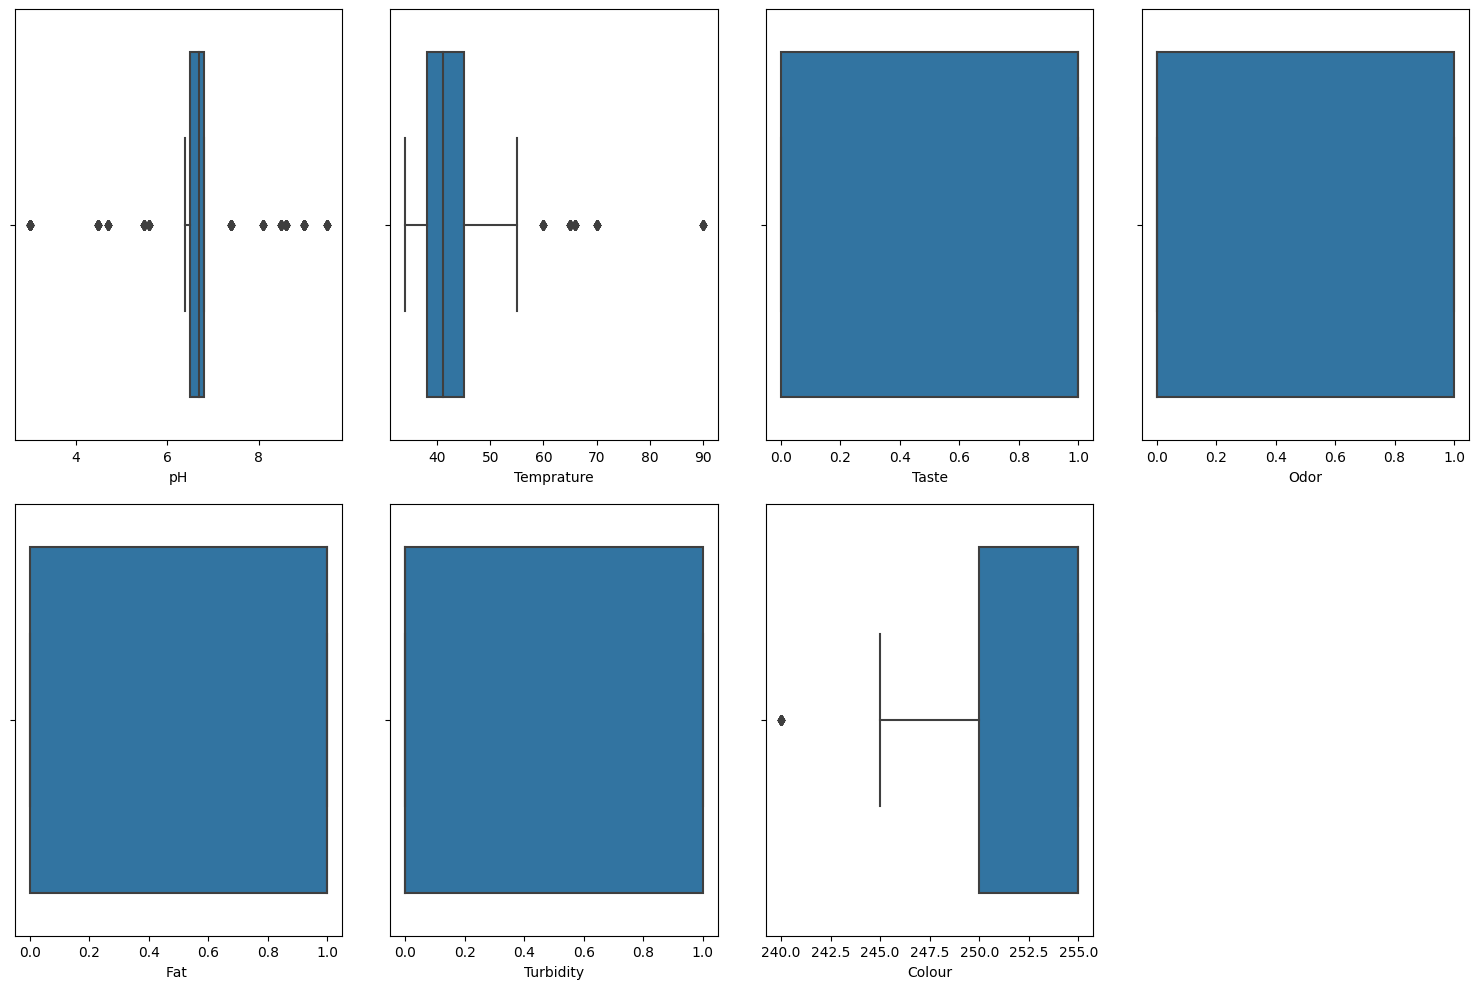

In [14]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15,10))
axs = axs.flatten()

for i, var in enumerate(data.columns):
  if var == 'Grade':
    break
  else:
    sns.boxplot(x = var, data= data, ax = axs[i])

fig.tight_layout()
fig.delaxes(axs[7])
# plt.xlabel(i)
plt.show()

<ipython-input-15-2c171a1e8d9e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), fmt='.2g', annot=True)


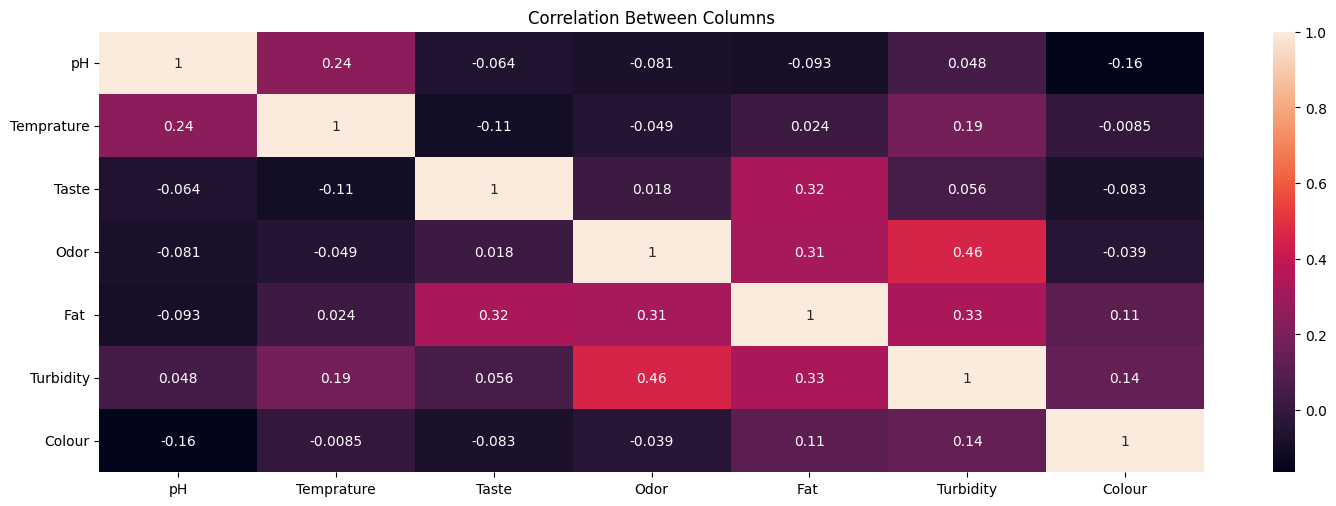

In [15]:
plt.figure(figsize=(15,5))
sns.heatmap(data.corr(), fmt='.2g', annot=True)
plt.tight_layout()
plt.title('Correlation Between Columns')
plt.show()

# Train Test Split

In [17]:
x = data.drop('Grade', axis = 1)
y = data['Grade']

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

(212,)

In [19]:
print(x_train.shape,
x_test.shape,
y_train.shape,
y_test.shape)

(847, 7) (212, 7) (847,) (212,)


# Remove The Outliers

In [20]:
x_train.columns

Index(['pH', 'Temprature', 'Taste', 'Odor', 'Fat ', 'Turbidity', 'Colour'], dtype='object')

In [21]:
from scipy.stats import stats

selected_columns = ['pH', 'Temprature', 'Taste', 'Odor', 'Fat ', 'Turbidity', 'Colour']

z = np.abs(stats.zscore(x_train[selected_columns]))

threshold = 3

outliers_indices = np.where(z > threshold)[0]

x_train = x_train.drop(x_train.index[outliers_indices])
y_train = y_train.drop(y_train.index[outliers_indices])

<ipython-input-21-17b621702b1a>:5: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  z = np.abs(stats.zscore(x_train[selected_columns]))


# Modelling

# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dtree = DecisionTreeClassifier(class_weight='balanced')
param_grids = {
    'max_depth' : [3,4,5,6,7,8],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1, 2, 3, 4],
    'random_state' : [0, 42],
}

grid_search = GridSearchCV(dtree, param_grids, cv=5)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}


In [25]:
dtree = DecisionTreeClassifier(max_depth=8, min_samples_leaf=1, min_samples_split=2, random_state=42).fit(x_train, y_train)

In [26]:
from sklearn.metrics import accuracy_score

y_pred = dtree.predict(x_test)
print('Accuracy Score :', round(accuracy_score(y_pred, y_test) * 100, 2),'%')

Accuracy Score : 95.28 %


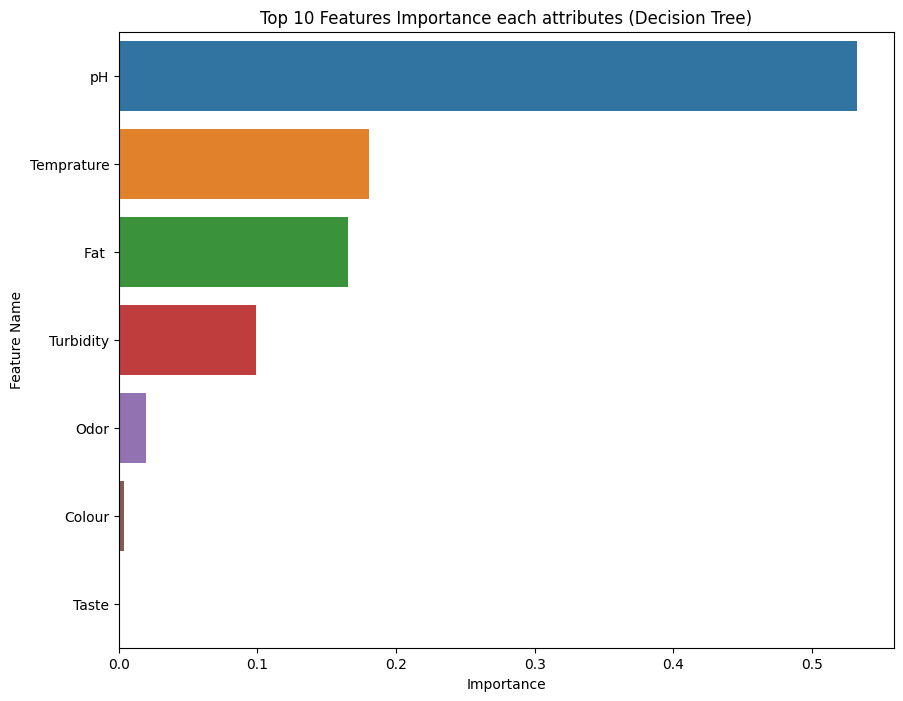

In [27]:
imp_df = pd.DataFrame({
    'Feature Name' : x_train.columns,
    'Importance' : dtree.feature_importances_
})
fi = imp_df.sort_values(by='Importance', ascending = False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data = fi2, x='Importance', y = 'Feature Name')
plt.title('Top 10 Features Importance each attributes (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.show()


# Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(gbc, param_grid, cv=5)
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
GradientBoostingClassifier(max_depth=7, subsample=0.8)


In [29]:
gbc = GradientBoostingClassifier(learning_rate=0.1, max_depth = 7, min_samples_leaf=1, min_samples_split = 2, n_estimators = 100, subsample=0.8).fit(x_train, y_train)

In [30]:
from sklearn.metrics import accuracy_score

y_pred = gbc.predict(x_test)
print('Accuracy Score :', round(accuracy_score(y_pred, y_test) * 100, 2),'%')

Accuracy Score : 99.06 %


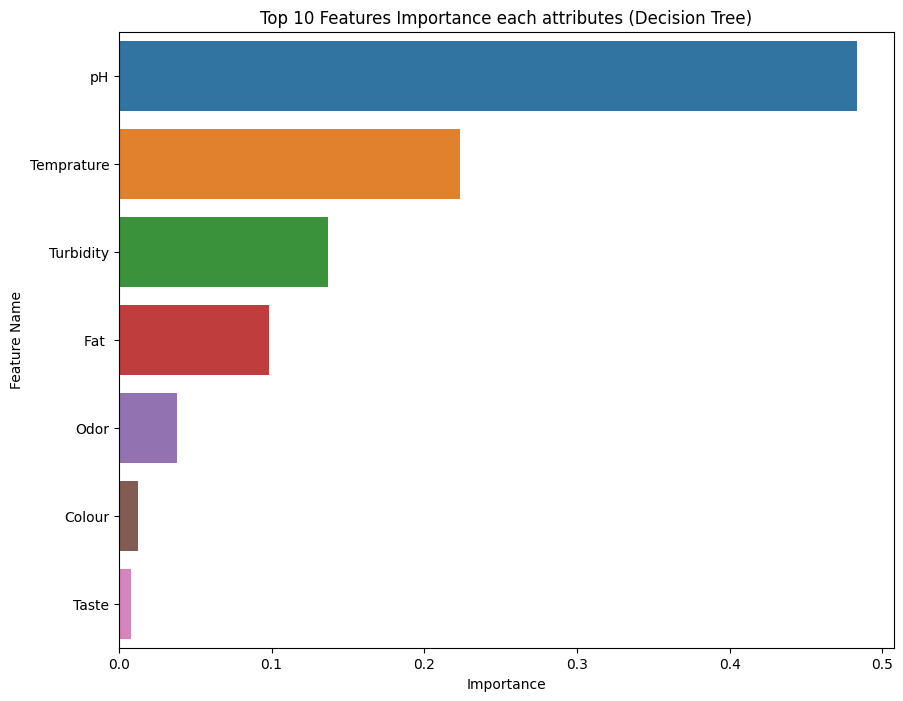

In [45]:
imp_df = pd.DataFrame({
    'Feature Name' : x_train.columns,
    'Importance' : gbc.feature_importances_
})
fi = imp_df.sort_values(by='Importance', ascending = False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data = fi2, x='Importance', y = 'Feature Name')
plt.title('Top 10 Features Importance each attributes (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.show()
